# Basis Set Timing Comparison

Compares ωB97X isotropic polarizability results using 4 different basis sets.  
Uses mike_copolymers, luke_homopolymers, and vds species.  

Generates 2 plots and 1 table:
- 1x3 multiplot
- Box plot of timings
- Table comparing relative performance of each basis set to "best" (aug-cc-pVTZ)
    
Note: produces identical figures at 300 dpi in pdf and png format, commented out to prevent accidental overwrite

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

### Data Processing

Load polarizability benchmark master data file

In [2]:
master_file = '../data/polar_benchmark_master.csv'
master_df = pd.read_csv(master_file)
master_df.tail()

,ID,subset,GFN2,wB97X/cc-pVDZ,wB97X/cc-pVTZ,wB97X/jun-cc-pVTZ,wB97X/aug-cc-pVTZ
68,1175_67_010101,ga_hexamers,246.577641,399.132205,420.328366,-1.0,-1.0
69,410_658_001000,ga_hexamers,256.029135,371.953863,392.290343,-1.0,-1.0
70,867_397_111011,ga_hexamers,259.184933,409.379205,432.635864,-1.0,-1.0
71,379_282_000100,ga_hexamers,260.776229,441.802262,464.997122,-1.0,-1.0
72,379_525_001000,ga_hexamers,276.044063,430.469069,415.776671,-1.0,-1.0


Make basis set df by slicing master df

In [3]:
basis_df = master_df[(master_df['subset'] == 'mike_copolymers') | (master_df['subset'] == 'luke_homopolymers') | (master_df['subset'] == 'vds')]
basis_df = basis_df.reset_index(drop=True)
basis_df.tail()

,ID,subset,GFN2,wB97X/cc-pVDZ,wB97X/cc-pVTZ,wB97X/jun-cc-pVTZ,wB97X/aug-cc-pVTZ
14,5-sp80,luke_homopolymers,67.971134,129.935713,135.198677,139.184680,139.708116
15,5-sp78,luke_homopolymers,68.023048,131.988126,138.275485,142.618422,143.146685
16,46-47_AB3,mike_copolymers,77.740000,222.679261,229.038035,233.718701,235.626701
17,47-50_AB3,mike_copolymers,78.816302,146.505816,151.845393,156.392561,157.250697
18,5-sp63,luke_homopolymers,91.129226,112.184130,121.723763,129.139733,128.433221


Load timing data files

In [4]:
vdz_df = pd.read_csv('../data/cc-pvdz_timing.csv')
vtz_df = pd.read_csv('../data/cc-pvtz_timing.csv')
jun_df = pd.read_csv('../data/jun-cc-pvtz_timing.csv')
aug_df = pd.read_csv('../data/aug-cc-pvtz_timing.csv')

### Method Definition

In [5]:
'''
    Calculates root mean square error

    Parameters
    ---------
    predictions: ndarray of floats
        expected values [based on best fit line]
    observations: ndarray of floats
        observed values
    
    Returns
    -------
    rmse: float
        root mean square error
'''
def calc_rmse(predictions, observations):
    rmse = np.sqrt(((predictions - observations) ** 2).mean())
    return rmse

In [6]:
'''
    Performs linear regression on data set and calculates associated values

    Parameters
    ---------
    x: ndarray of floats
        x values
    y: ndarray of floats
        y values
    intercept: boolean
        if true, calculates y intercept, if false sets y intercept to 0 (forces fit)
    
    Returns
    -------
    lin_regress_var: list of floats
        slope, y-intercept, r^2, root mean square error
'''

def perform_lin_regress(x, y, intercept=True):  
     
    # 2D X array necessary for sklearn
    xi = x.reshape((-1,1))

    model = LinearRegression(fit_intercept = intercept)
    model.fit(xi,y)
    
    slope = model.coef_[0]
    intercept = model.intercept_
    r_squared = model.score(xi,y)

    # calculate RMSE
    y_pred = y
    y_true = []
    for val in x: 
        y_tr = slope*val + intercept
        y_true.append(y_tr)
    y_true = np.array(y_true)

    rmse = calc_rmse(y_pred, y_true)
    
    lin_regress_var = [slope, intercept, r_squared, rmse]
    
    return lin_regress_var

In [7]:
# matplotlib global formatting

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

plt.rcParams['figure.dpi'] = 300

## ωB97X Basis Set Comparison Plot

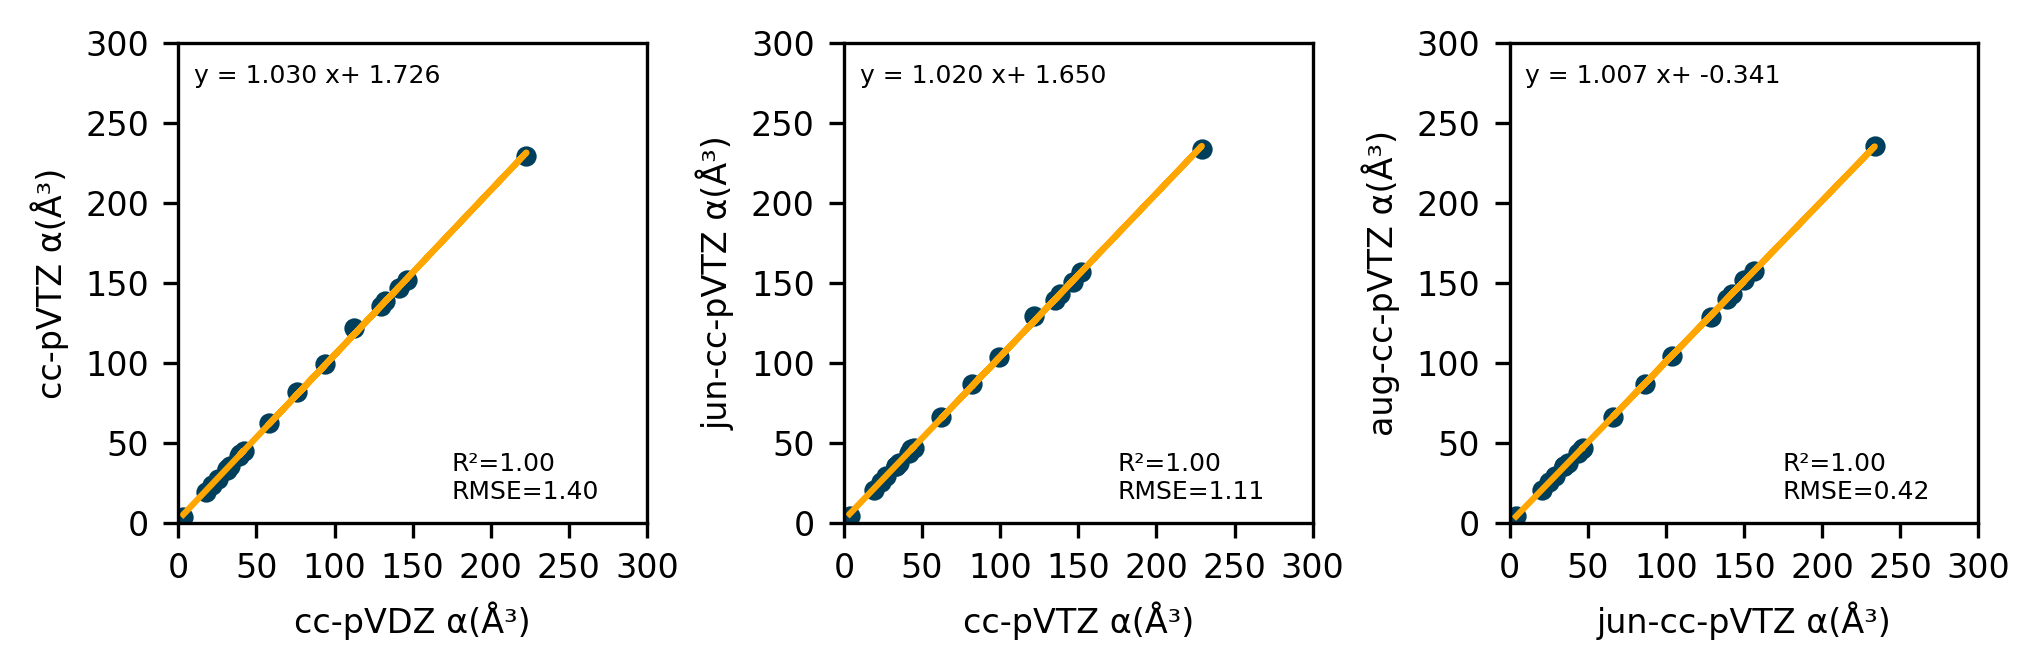

In [8]:
# set up subplot figure
fig, axs = plt.subplots(1, 3)
top = 0.4
bottom = 0
left = 0
right = 1
plt.subplots_adjust(top=top, bottom=bottom, left=left, right=right, wspace=0.42)

# set figure axes
xlimits = (0, 300)
xticks = [0, 50, 100, 150, 200, 250, 300]
ylimits = (0, 300)
yticks = [0, 50, 100, 150, 200, 250, 300]

# SUBPLOT 0: cc-pVTZ vs cc-pVDZ
x=basis_df['wB97X/cc-pVDZ'].values
y=basis_df['wB97X/cc-pVTZ'].values

axs[0].set(ylim=ylimits, xlim=xlimits)
axs[0].set_xlabel('cc-pVDZ α(Å³)')
axs[0].set_ylabel('cc-pVTZ α(Å³)')
axs[0].set_xticks(xticks)
axs[0].set_yticks(yticks)

# perform linear regression
slope, intercept, r_squared, rmserror = perform_lin_regress(x, y)

# plot points & regression line
axs[0].scatter(x, y, s=15, c='#003f5c')
axs[0].plot(x, slope*x+intercept, c='#ffa600')

# print regression line equation & r-squared
axs[0].text(10, 275, 'y = %.3f x+ %.3f' % (slope, intercept))
axs[0].text(175, 15,'R²={:.2f}\nRMSE={:.2f}'.format(r_squared, rmserror))


# SUBPLOT 1: jun-cc-pVDZ vs cc-pVTZ
x=basis_df['wB97X/cc-pVTZ'].values
y=basis_df['wB97X/jun-cc-pVTZ'].values

axs[1].set(ylim=ylimits, xlim=xlimits)
axs[1].set_xlabel('cc-pVTZ α(Å³)')
axs[1].set_ylabel('jun-cc-pVTZ α(Å³)')
axs[1].set_xticks(xticks)
axs[1].set_yticks(yticks)

# perform linear regression
slope, intercept, r_squared, rmserror = perform_lin_regress(x, y)

# plot points & regression line
axs[1].scatter(x, y, s=15, c='#003f5c')
axs[1].plot(x, slope*x+intercept, c='#ffa600')

# print regression line equation & r-squared
axs[1].text(10, 275, 'y = %.3f x+ %.3f' % (slope, intercept))
axs[1].text(175, 15,'R²={:.2f}\nRMSE={:.2f}'.format(r_squared, rmserror))


# SUBPLOT 2: aug-cc-pVTZ vs jun-cc-pVTZ
x=basis_df['wB97X/jun-cc-pVTZ'].values
y=basis_df['wB97X/aug-cc-pVTZ'].values

axs[2].set(ylim=ylimits, xlim=xlimits)
axs[2].set_xlabel('jun-cc-pVTZ α(Å³)')
axs[2].set_ylabel('aug-cc-pVTZ α(Å³)')
axs[2].set_xticks(xticks)
axs[2].set_yticks(yticks)

# perform linear regression
slope, intercept, r_squared, rmserror = perform_lin_regress(x, y)

# plot points & regression line
axs[2].scatter(x, y, s=15,  c='#003f5c')
axs[2].plot(x, slope*x+intercept, c='#ffa600')

# print regression line equation & r-squared
axs[2].text(10, 275, 'y = %.3f x+ %.3f' % (slope, intercept))
axs[2].text(175, 15,'R²={:.2f}\nRMSE={:.2f}'.format(r_squared, rmserror))

# plt.savefig('basis_comparison_multiplot.pdf', transparent=False, bbox_inches='tight')
# plt.savefig('basis_comparison_multiplot.png', transparent=False, bbox_inches='tight')

plt.show()

## Timing Box Plot

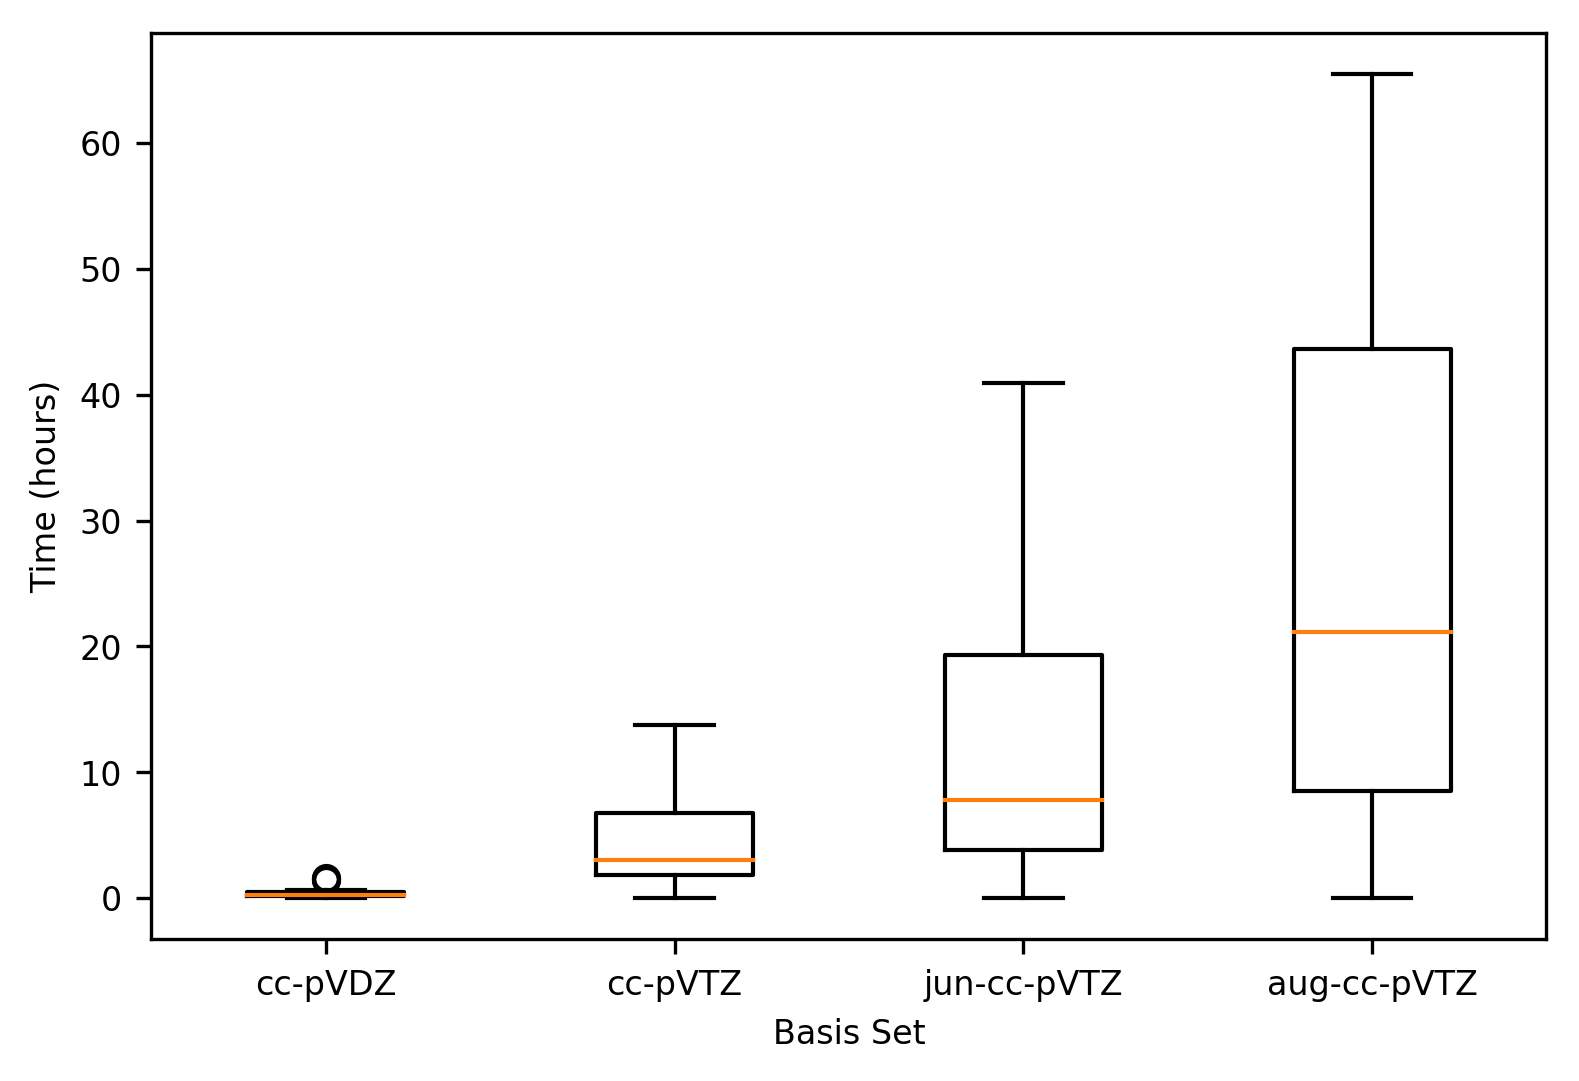

In [9]:
data = [vdz_df['time(hours)'], vtz_df['time(hours)'], jun_df['time(hours)'], aug_df['time(hours)']]
fig, ax = plt.subplots()
ax.boxplot(data, labels=['cc-pVDZ', 'cc-pVTZ', 'jun-cc-pVTZ', 'aug-cc-pVTZ'])
plt.xlabel('Basis Set')
plt.ylabel('Time (hours)')

# plt.savefig('basis_comparison_boxplot.pdf', transparent=False, bbox_inches='tight')
# plt.savefig('basis_comparison_boxplot.png', transparent=False, bbox_inches='tight')

plt.show()

## Basis Set Comparison Table

Construct table to compare aug-cc-pVTZ results against the other three basis sets used with wB97X

In [10]:
# calculate timing compared to aug-cc-pVTZ

vdz_avg = vdz_df['time(hours)'].mean()
vtz_avg = vtz_df['time(hours)'].mean()
jun_avg = jun_df['time(hours)'].mean()
aug_avg = aug_df['time(hours)'].mean()

vdz_timing = aug_avg/vdz_avg
vtz_timing = aug_avg/vtz_avg
jun_timing = aug_avg/jun_avg

timing_list = [vdz_timing, vtz_timing, jun_timing]

In [11]:
table_df = pd.DataFrame()

basis_list = ['cc-pVDZ', 'cc-pVTZ', 'jun-cc-pVTZ']

y = basis_df['wB97X/aug-cc-pVTZ'].values
for count, basis in enumerate(basis_list):
    x = basis_df['wB97X/%s' % basis].values
    
    # perform linear regression
    slope, intercept, r_squared, rmserror = perform_lin_regress(x, y)
    
    fit_fn = 'y = %.3f x + %.3f' % (slope, intercept)
    r_squared = '%.3f' % r_squared
    rmserror = '%.3f' % rmserror
    timing = '%.3f' % timing_list[count]
    
    temp_df = pd.DataFrame({'basis':[basis], 'fit_fn':[fit_fn], 'r^2':[r_squared], 'RMSE':[rmserror], 'timing':[timing]})
    table_df = table_df.append(temp_df, ignore_index=True)

In [12]:
table_df

,basis,fit_fn,r^2,RMSE,timing
0,cc-pVDZ,y = 1.059 x + 3.108,0.999,2.163,63.211
1,cc-pVTZ,y = 1.028 x + 1.312,1.000,0.755,5.941
2,jun-cc-pVTZ,y = 1.007 x + -0.341,1.000,0.424,2.213
